# Simulation: 
Find reference control law

In [1]:
import numpy as np

from scipy.integrate import odeint
import scipy.interpolate as interp  
from scipy.interpolate import griddata 
import scipy.ndimage as ndimage 

import matplotlib.pyplot as plt  
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
import matplotlib
from matplotlib import rc 

import time    
import seaborn as sns
import os
import sys

# append function path to system
base_path = os.path.abspath(os.path.join( os.getcwd()   , os.pardir ) )
function_path = os.path.join(  base_path, 'functions') 
sys.path.append(function_path ) 
 
figs_path = os.path.join(  base_path, 'figs') 
data_path = os.path.join(  base_path, 'data')
    
# import custom functions 
from figure_settings import *    
import figure_functions as ff
import phasediagram as phd
import singlependulum as sp  

# Set simulation parameters and initial conditions

In [2]:

# ---time step per simulation ------ 
bool_highRes = False

if bool_highRes:
    dtU = 0.01
    dt_set= 0.05
    save_filename = 'reference_control_law_highRes.npy'
else:
    dtU = 0.3
    dt_set= 0.3
    save_filename = 'reference_control_law_lowRes.npy'
    
tLast = 7
tU = np.linspace(0,dtU,2) # ---time step per simulation ------   
n_steps = np.int(tLast/dt_set)
print('Number of time steps: '+ str(n_steps) ) 
t_start = time.time()  
 
#-----------child radius----------
rad = dt_set/2.5

#-----------grid size---------- 
y_lim = 10 
# x_steps = 120  + 1 
# y_steps = 240 + 1
x_steps = 60  + 1 
y_steps = 120 + 1

#-----------grid size----------   
x_space = np.linspace(-np.pi,np.pi, x_steps)
y_space = np.linspace(-y_lim,y_lim, y_steps) 
X, Y = np.meshgrid(x_space,y_space) 
 
max_velocity = 10
# ----------physics --------
g = -10
L = 1
mp = 1
Ed = 10 

# ---------controller ------------
R = 100
Q = 1 
u_clip = 3 
n_u = 3  # discretize different control options  
u_opts = np.linspace(-u_clip,u_clip,n_u)


# ---------simulation par  ------------
n_points = 400000  # storage limit   
n_slices = 51    # filter slices 

#----------plotting options ------
intermediate_plotting = False
# intermediate_plotting = True

# #---------array of  ICs ----------------------------
n_theta = 200
theta = np.linspace(-np.pi,np.pi, n_theta,endpoint=False)
dTheta = np.sqrt( -2*g - 2*g*np.cos(theta) ) 
one0 = np.ones( (n_theta,3)) 
U0 = np.ones( (n_theta,1)) 

IC0 = np.vstack( (np.column_stack( (theta,dTheta,one0,U0)   ) , 
                np.column_stack( (-theta,-dTheta,one0,U0)   ) )  )   

#---plotting parameters----------------------------------
max_J = 7
plt.style.use('latex_scientificPaperStyle.mplstyle')

col = sns.color_palette("hls", 5)  
colorsList = [col[2],np.array([255,255,200])/255,col[3]]  
contr = matplotlib.colors.ListedColormap(colorsList) 

plt.rc('font', family='serif')
rc('text', usetex=True) 

Number of time steps: 23


# Run simulation 

In [3]:
# initialize point matrix 
point_Mat = np.zeros(( n_points ,6))  
counter = len(IC0)  
point_Mat[:counter] = IC0   

tSave = t_start 
meta_counter = 1
time_sign = -1

for j in range(n_steps):  

    parent_bool = (  point_Mat[:,3]  == 1) &  (point_Mat[:,4]  == 1 )  
    elder_bool = (point_Mat[:,4]  == 1 )  
    subMat = point_Mat[parent_bool,:]  
    
    tNow = time.time()
    delT  = tNow-tSave 
    tSave = tNow 
    print( 'step: ' + str(j) + ', runtime: ' + str( round(tNow-t_start,1) ) + ' sec' + 
          ', dT: ' +  str( round(delT,1) ) + ' sec'  +   ', n_parents: '+str(np.sum(parent_bool ) ) + 
                ', n_elder: '+str(np.sum(elder_bool ))        )    
        
    newest_parent = counter
    for j in range( len(subMat) ):
        Ji = subMat[j,2] 
        yi = subMat[j,[0,1]]
        
        
        dt = dt_set/2+dt_set*np.random.rand(1)[0];  
        t = np.linspace(0,dt,2) # ---time step per simulation ------  
        rad = dt/3
 

        for u_c in u_opts:
            #-------solve ODE --------------------------------------
            yn = odeint(  sp.pendulum_ode, yi,  t, args=(u_c,time_sign,)  ) [1]    # ode solver 
            
            
            dist = np.sqrt( np.sum( (yi-yn)**2 ) )/3
            if dist < rad:
                rad = dist
            
            yn[0] = sp.wrap2periodic( yn[0] )
            Jn = sp.calc_costToGo(yi,u_c, Q,R )*dt + Ji 
            #---------------------------------------------    
            
            dist = np.sqrt(  (point_Mat[:,0] - yn[0] )**2 + (point_Mat[:,1] - yn[1] )**2  ) 
            overlap_bool = dist < rad 
            in_range = np.abs(yn[1]) < max_velocity
            
            # save point if: 
            if (len( point_Mat[overlap_bool,2]) == 0) & in_range:     # empty space found
                point_Mat[counter,:] = np.array([yn[0], yn[1],Jn,1,1,u_c]) 
                counter = counter + 1
            elif np.all( Jn < point_Mat[overlap_bool,2] ) & in_range : # cheapest in the neighborhood 
                point_Mat[counter,:] = np.array([yn[0], yn[1],Jn,1,1,u_c])  
                point_Mat[overlap_bool,4] = 0 # turn off defeated points
                counter = counter + 1  
                
    if intermediate_plotting: 
        f, axs = plt.subplots(1,1,figsize=(10,5) )   
         
        axs.scatter( point_Mat[elder_bool,0], point_Mat[elder_bool,1] ,1 ,'g') 
        axs.scatter( point_Mat[parent_bool,0], point_Mat[parent_bool,1] ,1 ,'r') 
        axs.scatter( point_Mat[newest_parent:counter,0], point_Mat[newest_parent:counter,1] ,1 ,'b') 
          
        axs.set_xlim( [-np.pi,np.pi] )
        axs.set_ylim([-9,9])
        
        phd.homoclinic_plot( axs )
        plt.show()
         
    # turn off parent activity for point 
    point_Mat[parent_bool,3] = 0
    
    elder_bool = (point_Mat[:,4]  == 1 )  
    if counter > meta_counter*10000:
        print('Matrix trimming')
        meta_counter = meta_counter +1 
        tempMat = point_Mat[elder_bool,:]
         
        counter = np.shape(tempMat)[0]  
        point_Mat = np.zeros((n_points ,6))
        point_Mat[:counter,:] = tempMat
 
elder_bool = (point_Mat[:,4]  == 1 )    
meta_counter = meta_counter +1
tempMat = point_Mat[elder_bool,:]
 
counter = np.shape(tempMat)[0] 

point_Mat = np.zeros((n_points ,6))
point_Mat[:counter,:] = tempMat
elder_bool = (point_Mat[:,4]  == 1 )    


grid_raw = griddata( point_Mat[elder_bool,:2] ,   point_Mat[elder_bool,2], (X, Y), method='linear') 

J_raw, J_raw_log = sp.matrix_fillnan(grid_raw) 

step: 0, runtime: 0.1 sec, dT: 0.1 sec, n_parents: 400, n_elder: 400
step: 1, runtime: 20.8 sec, dT: 20.7 sec, n_parents: 513, n_elder: 913
step: 2, runtime: 47.0 sec, dT: 26.2 sec, n_parents: 754, n_elder: 1585
step: 3, runtime: 86.1 sec, dT: 39.1 sec, n_parents: 934, n_elder: 2354
step: 4, runtime: 135.7 sec, dT: 49.6 sec, n_parents: 1077, n_elder: 3189
step: 5, runtime: 192.6 sec, dT: 56.9 sec, n_parents: 1154, n_elder: 4019
step: 6, runtime: 254.3 sec, dT: 61.7 sec, n_parents: 1141, n_elder: 4829
step: 7, runtime: 324.7 sec, dT: 70.4 sec, n_parents: 948, n_elder: 5379
step: 8, runtime: 391.2 sec, dT: 66.5 sec, n_parents: 752, n_elder: 5832
step: 9, runtime: 433.2 sec, dT: 42.0 sec, n_parents: 542, n_elder: 6140
step: 10, runtime: 464.0 sec, dT: 30.8 sec, n_parents: 392, n_elder: 6363
Matrix trimming
step: 11, runtime: 486.3 sec, dT: 22.3 sec, n_parents: 291, n_elder: 6528
step: 12, runtime: 500.5 sec, dT: 14.2 sec, n_parents: 221, n_elder: 6630
step: 13, runtime: 511.3 sec, dT: 10.

# Filter out high-cost points

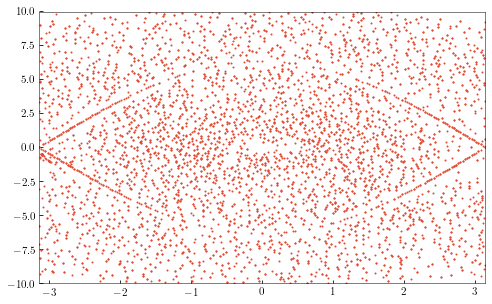

In [5]:
n_slices = 201
intermediate_plotting = False 
angle_range = np.linspace(-np.pi,np.pi,n_slices)

d_angle = angle_range[1]-angle_range[0]
overlap = 1

elder_bool = (point_Mat[:,4]  == 1 )

pos_angle = np.expand_dims( np.arctan2( point_Mat[elder_bool,1] , point_Mat[elder_bool,0]) ,  axis=1)
pos_E = np.expand_dims( sp.compute_dE( point_Mat[elder_bool,0], point_Mat[elder_bool,1] ),  axis=1)
 
data = np.concatenate( ( point_Mat[elder_bool,:] ,pos_E ,pos_angle ) ,axis=1 )
 
keepList = [] 

for j in range(len(angle_range)):    
    
    low_lim = angle_range[j]-(d_angle/2)*(1+overlap)
    high_lim = angle_range[j]+(d_angle/2)*(1+overlap)
    in_range = (pos_angle>low_lim) & (pos_angle<high_lim)
 
    tempData = data[in_range[:,0],:]
    ind_sorted = np.argsort( tempData[:,6])
    tempData2 = tempData[ind_sorted,:] 
    
    minV= np.min(tempData2[:,2])
    minI= np.argmin(tempData2[:,2])
    
    minJList = []
    minJListUp = [] 
    minJList.append(tempData2[0]) 
    minJListUp.append(tempData2[-1]) 
     
    for k in range(len(tempData2)):
        if tempData2[k,2] < minJList[-1][2]:
            minJList.append(tempData2[k,:]) 
            keepList.append(tempData2[k,:]) 
    for k in reversed(range(len(tempData2)) ):
        if tempData2[k,2] < minJListUp[-1][2]:
            minJListUp.append(tempData2[k,:]) 
            keepList.append(tempData2[k,:])  
    minMat = np.asarray(minJList) 
    minMatUp = np.asarray(minJListUp)  
    
    if intermediate_plotting == True: 
        f, axs = plt.subplots(1,1 ,figsize=(8,5) )    
        axs.scatter( tempData2[minI,6],  tempData2[minI,2] ,100, 'r')   
        axs.scatter( tempData2[:,6] , tempData2[:,2] ,1,'g')
        axs.scatter( minMat[:,6] , minMat[:,2] ,1,'b')
        axs.scatter( minMatUp[:,6] , minMatUp[:,2] ,1,'b')

        axs.set_xlim([-20,20]) 
        axs.set_ylim([-50,3000]) 
        axs.set_xlabel('Total energy')
        axs.set_ylabel('Cost J') 
     
point_Mat_filt = np.asarray(keepList)  
 
f, axs = plt.subplots(1,1 ,figsize=(8,5) )    
axs.scatter( point_Mat_filt[:,0], point_Mat_filt[:,1] , 1 )

# Filter cost function 

In [7]:
filter_on = True 

if filter_on:
    elder_bool = (point_Mat_filt[:,4]  == 1 )
    grid_z1 = griddata( point_Mat_filt[elder_bool,:2] ,   point_Mat_filt[elder_bool,2], (X, Y), method='linear') 
else:
    grid_z1 = grid_raw

J_filter, J_filter_log = sp.matrix_fillnan(grid_z1)   

In [8]:
print('time to run so far: ' + str(round(time.time()-t_start,1)) + ' seconds')

time to run so far: 537.0 seconds


# Mirror cost function around -np.pi and np.pi vertices

In [9]:
# combine griddata  
point_Mat_elder = point_Mat_filt 

point_Mat_elder_2 = point_Mat_elder.copy()
point_Mat_elder_2[:,0] = point_Mat_elder[:,0]-2*np.pi  

point_Mat_elder_3 = point_Mat_elder.copy()
point_Mat_elder_3[:,0] = point_Mat_elder[:,0]+2*np.pi  

point_Mat_combined = np.vstack( (point_Mat_elder, point_Mat_elder_2,point_Mat_elder_3)  )
point_Mat_combined[:,7]= np.arctan2( point_Mat_combined[:,1], point_Mat_combined[:,0]  ) 


# Smooth data with gaussian 

In [10]:
elder_bool = (point_Mat_combined[:,4]  == 1 )
grid_z1 = griddata( point_Mat_combined[elder_bool,:2] ,   point_Mat_combined[elder_bool,2], (X, Y), method='linear') 

J_combined, J_combined_log = sp.matrix_fillnan(grid_z1)   

Gauss_width = 2   

J_smooth_raw = ndimage.gaussian_filter(J_combined, sigma=Gauss_width, order=0) 
J_smooth, J_smooth_log = sp.matrix_fillnan(J_smooth_raw)  

# Plot reference control map

time to run so far: 548.7 seconds


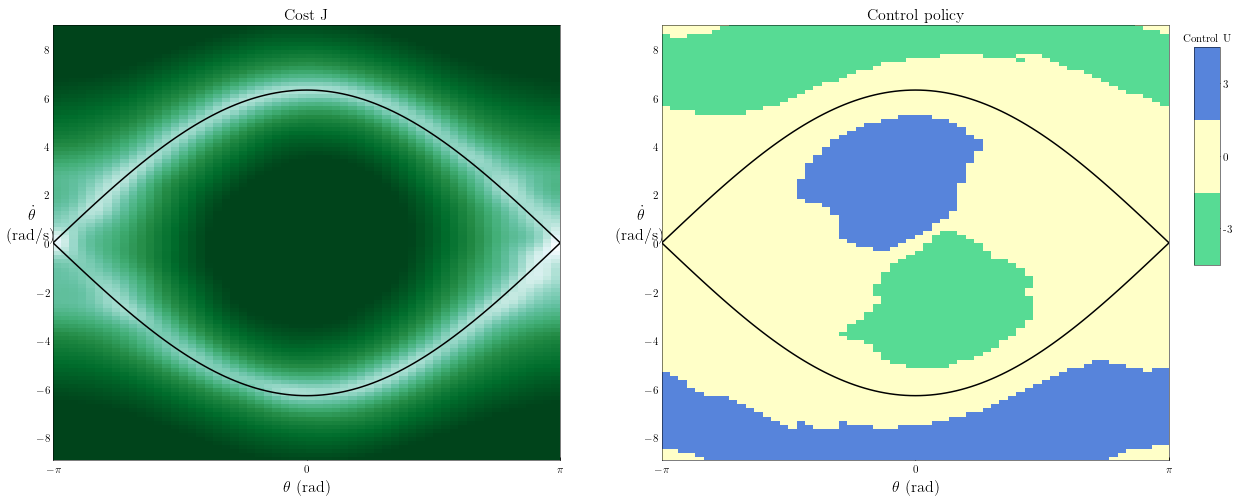

In [11]:
f, axs = plt.subplots(1,2 ,figsize=(20,8) )   
 
axs[0].pcolor(X,Y, J_smooth_log,vmax = max_J , cmap='BuGn' )      
axs[0] = phd.homoclinic_plot(axs[0]) 
     
# figure style 
axs[0].xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))  
 
axs[0].set_xlabel(r' $\theta$ (rad)',fontsize = 16)
axs[0].set_ylabel(r"$\dot{\theta}$"  "\n"  "(rad/s)",fontsize = 16,rotation = 0) 
axs[0].set_title('Cost J',fontsize = 16)  

axs[0].set_xlim([-np.pi,np.pi])
axs[0].set_ylim([-9,9])
  
    
    
U_comp = sp.compute_U( J_smooth, x_space, y_space, X,Y, u_opts, tU, Q,R) 

pcol= axs[1].pcolor(X,Y, U_comp , cmap= contr )   

axs[1] = phd.homoclinic_plot(axs[1])
axs[1].set_xlim([-np.pi,np.pi])
axs[1].set_ylim([-9,9])

axs[1].set_xlabel(r' $\theta$ (rad)',fontsize = 16)
axs[1].set_ylabel(r"$\dot{\theta}$"  "\n"  "(rad/s)",fontsize = 16,rotation = 0) 
axs[1].xaxis.set_major_locator(plt.MultipleLocator(np.pi )) 
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(phd.multiple_formatter()))  
axs[1].set_title('Control policy',fontsize = 16)  
 
axins = inset_axes(axs[1],
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.45, 1, 1),
                   bbox_transform=axs[1].transAxes,
                   borderpad=0,
                   ) 

cbar = f.colorbar(pcol, cax=axins , ticks=[-2,0,2] )
cbar.ax.set_yticklabels([-3,0,3])  # vertically oriented colorbar
cbar.ax.set_title('Control U')  

print('time to run so far: ' + str(round(time.time()-t_start,1)) + ' seconds')  

# Save data

In [12]:
filename_reference = os.path.join( data_path, save_filename ) 
np.save( filename_reference, (U_comp,X,Y) )  